In [20]:
import os
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
import torch.nn.functional as F

In [2]:
import random

my_seed = 1
random.seed(my_seed)
torch.manual_seed(my_seed)
pl.seed_everything(my_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

batch_size = 64
max_epochs = 500
input_size = 96
num_ftrs = 32

Global seed set to 1


In [3]:
path_to_data = 'hw2/unlabeled/'

In [4]:
collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    vf_prob=0.5,
    rr_prob=0.5
)

# We create a torchvision transformation for embedding the dataset after
# training
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_train_simclr = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [5]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [6]:
gpus = 1 if torch.cuda.is_available() else 0

model = SimCLRModel()
trainer = pl.Trainer(
    max_epochs=max_epochs, gpus=gpus, progress_bar_refresh_rate=100
)
trainer.fit(model, dataloader_train_simclr)

C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       |

Training: 0it [00:00, ?it/s]

In [7]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames

In [8]:
model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

In [9]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array
    """
    img = Image.open(filename)
    return np.asarray(img)

In [10]:
def plot_knn_examples(embeddings, filenames, n_neighbors=5, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            # let's disable the axis
            plt.axis('off')

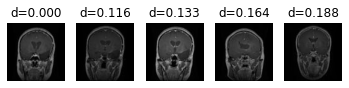

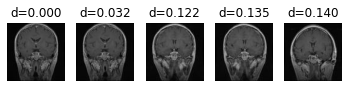

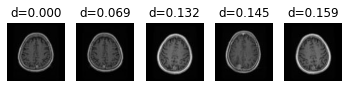

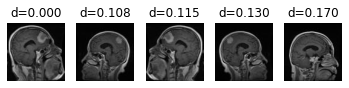

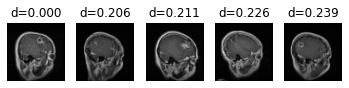

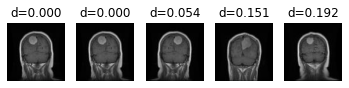

In [11]:
plot_knn_examples(embeddings, filenames)

In [12]:
embedding = np.array(embeddings, dtype="float32")
np.save('310581013', embedding)

In [13]:
embedding_train = np.load('310581013.npy')
print(embedding_train.dtype)
print(embedding_train.shape)

float32
(7294, 512)


In [14]:
testset0 = lightly.data.LightlyDataset(
    input_dir='hw2/test/0/',
    transform=test_transforms
)
testset1 = lightly.data.LightlyDataset(
    input_dir='hw2/test/1/',
    transform=test_transforms
)
testset2 = lightly.data.LightlyDataset(
    input_dir='hw2/test/2/',
    transform=test_transforms
)
testset3 = lightly.data.LightlyDataset(
    input_dir='hw2/test/3/',
    transform=test_transforms
)

testset_simclr = torch.utils.data.ConcatDataset([testset0, testset1, testset2, testset3])

testloader = torch.utils.data.DataLoader(
    testset_simclr,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

In [15]:
model.eval()
embeddings, filenames = generate_embeddings(model, testloader)

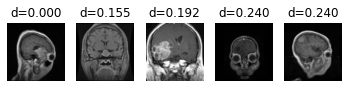

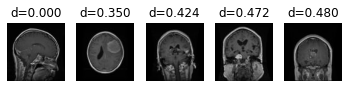

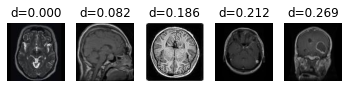

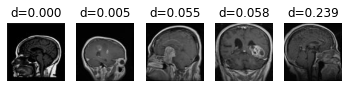

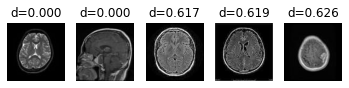

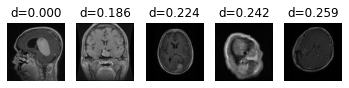

In [16]:
plot_knn_examples(embeddings, filenames)

In [17]:
embedding_test = np.array(embeddings, dtype="float32")
print(embedding_test.dtype)
print(embedding_test.shape)

float32
(500, 512)


In [18]:
def KNN(emb, cls, batch_size, Ks=[1, 10, 50, 100]):
    """Apply KNN for different K and return the maximum acc"""
    preds = []
    mask = torch.eye(batch_size).bool().to(emb.device)
    mask = F.pad(mask, (0, len(emb) - batch_size))
    for batch_x in torch.split(emb, batch_size):
        dist = torch.norm(
            batch_x.unsqueeze(1) - emb.unsqueeze(0), dim=2, p="fro")
        now_batch_size = len(batch_x)
        mask = mask[:now_batch_size]
        dist = torch.masked_fill(dist, mask, float('inf'))
        # update mask
        mask = F.pad(mask[:, :-now_batch_size], (now_batch_size, 0))
        pred = []
        for K in Ks:
            knn = dist.topk(K, dim=1, largest=False).indices
            knn = cls[knn].cpu()
            pred.append(torch.mode(knn).values)
        pred = torch.stack(pred, dim=0)
        preds.append(pred)
    preds = torch.cat(preds, dim=1)
    accs = [(pred == cls.cpu()).float().mean().item() for pred in preds]
    return max(accs)

In [21]:
N = 125

embedding = torch.from_numpy(embedding_test)

classes = torch.cat([
    torch.full((N,1),0),
    torch.full((N,1),1),
    torch.full((N,1),2),
    torch.full((N,1),3)
], dim=0)

acc = KNN(embedding, classes.squeeze(), batch_size=16)
print("Accuracy: %.5f" % acc)

Accuracy: 0.97000


In [22]:
torch.save(model, './model.pth')